In [1]:
import os
import time
import math
import subprocess

from tqdm import tqdm
from glob import glob
from pathlib import Path
from tabulate import tabulate
from typing import Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall, AUC
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Input

In [2]:
def download_and_extract(download_url, download_path, output_dir):
    try:
        check_dependencies()

        # Download the file without progress display
        subprocess.run(["wget", "-q", download_url, "-O", download_path], check=True)

        # Check if the download was successful before proceeding
        if os.path.exists(download_path):
            # Create the output directory
            os.makedirs(output_dir, exist_ok=True)

            # Extract the contents
            extract_command = ["tar", "-xf", download_path, "-C", output_dir]
            subprocess.run(extract_command, check=True)

            # Remove the tar file after extraction
            os.remove(download_path)
            print("Download and extraction completed successfully.")
        else:
            print("Error: Failed to download the dataset.")
    except subprocess.CalledProcessError as e:
        print(f"Error: {str(e)}")

def check_dependencies():
    try:
        subprocess.run(["wget", "--version"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
        subprocess.run(["tar", "--version"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error: Dependency check failed. {e}")
        raise

In [3]:
# Variables
download_url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar"
# download_path = "/kaggle/working/256_ObjectCategories.tar" # kaggle
download_path = "/content/256_ObjectCategories.tar" # colab
# output_dir = "/kaggle/working/data" # kaggle
output_dir = "/content/data" # colab

# Function call
download_and_extract(download_url, download_path, output_dir)

Download and extraction completed successfully.


In [4]:
# data_path = Path(r"/kaggle/working/data/256_ObjectCategories") # for kaggle
data_path = Path(r"/content/data/256_ObjectCategories") # for colab


In [5]:
def count_images_per_class(path):
    """Prints the number of images in each class in the dataset."""
    print(f'{"Classes":>22} | {"Images":^6}')
    print("=" * 40)

    for folder in os.listdir(path):
        sample_size = len(os.listdir(path / folder))
        print(f"{folder.strip():<23s}|{sample_size}")

count_images_per_class(data_path)

               Classes | Images
182.self-propelled-lawn-mower|120
155.paperclip          |92
238.video-projector    |97
218.tennis-racket      |81
162.picnic-table       |91
253.faces-easy-101     |435
224.touring-bike       |110
029.cannon             |103
193.soccer-ball        |174
190.snake              |112
004.baseball-bat       |127
192.snowmobile         |112
113.hummingbird        |116
236.unicorn            |97
068.fern               |110
213.teddy-bear         |101
031.car-tire           |90
145.motorbikes-101     |798
187.skyscraper         |95
007.bat                |106
021.breadmaker         |142
229.tricycle           |95
124.killer-whale       |91
103.hibiscus           |111
165.pram               |88
013.birdbath           |98
159.people             |209
134.llama-101          |119
152.owl                |120
135.mailbox            |93
037.chess-board        |120
126.ladder             |242
114.ibis-101           |120
079.frisbee            |99
120.joy-stick          

In [6]:
RANDOM_STATE = 81
TEST_SIZE = 0.1
VALIDATION_SPLIT = 0.2

def prepare_data(path, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    """Prepares the training, validation, and test dataframes."""
    path = Path(path)
    if not path.is_dir():
        raise ValueError("Provided path is not a directory.")

    file_paths = []
    labels = []

    for class_dir in sorted(path.iterdir()):
        if class_dir.is_dir():
            class_name = class_dir.name.split(".")[1]

            files = list(class_dir.glob("*"))
            if not files:
                print(f"No files found in {class_dir}. Skipping.")
                continue

            class_labels = [class_name] * len(files)
            file_paths.extend(files)
            labels.extend(class_labels)

    print(f"Files: {len(file_paths)}\n"
          f"Labels: {len(labels)}\n")

    labels = pd.Series(labels, name='labels')
    df = pd.DataFrame({"file_paths": file_paths, "labels": labels})

    tr_df, te_df = train_test_split(df, test_size=test_size, stratify=df["labels"], random_state=random_state)
    tr_df, v_df = train_test_split(tr_df, test_size=VALIDATION_SPLIT, stratify=tr_df["labels"], random_state=random_state)

    print(f"Training Data: {tr_df.shape[0]} samples\n"
          f"Testing Data: {te_df.shape[0]} samples\n"
          f"Validation Data: {v_df.shape[0]} samples")

    return tr_df, v_df, te_df, df, labels

train_df, valid_df, test_df, df, labels = prepare_data(data_path)

Files: 30609
Labels: 30609

Training Data: 22038 samples
Testing Data: 3061 samples
Validation Data: 5510 samples


In [7]:
def create_counts_table(d, test_d, train_d, valid_d):
    """Creates and prints a table showing the distribution of classes."""
    df_labels = d["labels"]
    test_labels = test_d["labels"]
    train_labels = train_d["labels"]
    valid_labels = valid_d["labels"]

    print(f'{"Class":>19} | {"Test":^4} | {"Train":^5} | {"Valid":^5}')
    print("=" * 50)

    for c in df_labels.unique():
        test_count = list(test_labels).count(c)
        train_count = list(train_labels).count(c)
        valid_count = list(valid_labels).count(c)

        print(f"{c:>19} | {test_count:^4} | {train_count:^5} | {valid_count}")

create_counts_table(df, test_df, train_df, valid_df)

              Class | Test | Train | Valid
               ak47 |  10  |  70   | 18
      american-flag |  10  |  70   | 17
           backpack |  15  |  109  | 27
       baseball-bat |  13  |  91   | 23
     baseball-glove |  15  |  106  | 27
    basketball-hoop |  9   |  65   | 16
                bat |  11  |  76   | 19
            bathtub |  23  |  167  | 42
               bear |  10  |  74   | 18
           beer-mug |  9   |  68   | 17
          billiards |  28  |  200  | 50
         binoculars |  22  |  155  | 39
           birdbath |  10  |  70   | 18
              blimp |  9   |  62   | 15
         bonsai-101 |  12  |  88   | 22
           boom-box |  9   |  66   | 16
       bowling-ball |  10  |  75   | 19
        bowling-pin |  10  |  73   | 18
       boxing-glove |  12  |  90   | 22
          brain-101 |  8   |  60   | 15
         breadmaker |  14  |  102  | 26
         buddha-101 |  10  |  70   | 17
          bulldozer |  11  |  79   | 20
          butterfly |  11  |  81   | 

In [8]:
BATCH_SIZE = 6
TARGET_SIZE = (224, 224)

def load_data(df, b_size=BATCH_SIZE, shuffle=True, class_weights=None):
    """Loads the data using an ImageDataGenerator."""
    generator = ImageDataGenerator(rescale=1 / 255.)

    df["file_paths"] = df["file_paths"].astype(str)

    if class_weights:
        class_weights = {key: class_weights[key] for key in sorted(class_weights.keys())}
        class_weights

    data = generator.flow_from_dataframe(
        df,
        x_col="file_paths",
        y_col="labels",
        target_size=TARGET_SIZE,
        class_mode="categorical",
        shuffle=shuffle,
        batch_size=b_size,
        class_weight=class_weights,
        random_state=RANDOM_STATE
    )

    invalid_filenames = df.loc[~df['file_paths'].isin(data.filenames), 'file_paths']
    if not invalid_filenames.empty:
        print("Invalid filenames:", invalid_filenames.tolist())

    return data

train_data = load_data(train_df)
valid_data = load_data(valid_df, shuffle=False)
test_data = load_data(test_df, shuffle=False)

Found 22036 validated image filenames belonging to 257 classes.
Invalid filenames: ['/content/data/256_ObjectCategories/056.dog/greg', '/content/data/256_ObjectCategories/198.spider/RENAME2']
Found 5510 validated image filenames belonging to 257 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="file_paths". These filename(s) will be ignored.
  warnings.warn(


Found 3061 validated image filenames belonging to 257 classes.


In [9]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """Calculates the F1 score."""
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """Calculates the specificity."""
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """Calculates the sensitivity."""
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        This approach allows for a nuanced assessment of the model's ability to distinguish
        between different classes, making it particularly valuable in scenarios where classes
        may have varying levels of significance.

        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """Calculates the number of true positives."""
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """Calculates the number of false positives."""
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """Calculates the number of false negatives."""
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """Calculates the number of true negatives."""
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """Calculates the components of the confusion matrix."""
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

custom_metrics = create_metrics()

# precision_metric, recall_metric, f1_score_metric, specificity_metric, sensitivity_metric, mcc_metric, auc_metric = custom_metrics

In [10]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

base_model.summary()

14536120/14536120 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (R

In [11]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a custom model using the functional API
x = GlobalAveragePooling2D()(base_model.output)
# removed dense layers
output = Dense(257, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [12]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy", create_metrics()]
)

In [13]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
class TimeCallback(tf.keras.callbacks.Callback):
    """Custom callback to record epoch times and total training time."""

    def on_train_begin(self, logs: Optional[Dict] = None) -> None:
        """Initialize training start time and epoch times."""
        self.train_start_time = time.perf_counter()
        self.epoch_times = []

    def on_epoch_begin(self, epoch: int, logs: Optional[Dict] = None) -> None:
        """Record start time of each epoch."""
        self.epoch_start_time = time.perf_counter()

    def on_epoch_end(self, epoch: int, logs: Optional[Dict] = None) -> None:
        """Calculate and store epoch time."""
        epoch_time = time.perf_counter() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs: Optional[Dict] = None) -> None:
        """Calculate total training time."""
        if logs is not None:
            self.total_train_time = time.perf_counter() - self.train_start_time
            logs['total_train_time'] = self.total_train_time
            print(f"Total training time: {self.total_train_time} seconds")

# Create an instance of the TimeCallback
time_callback = TimeCallback()

In [15]:
total_epochs = 50

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=total_epochs,
    callbacks=[time_callback, early_stopping]
)

Epoch 1/50
3673/3673 [==============================] - 210s 48ms/step - loss: 2.4616 - accuracy: 0.4908 - precision_1: 0.9097 - recall_1: 0.2696 - f1_score: 0.3725 - specificity: 0.9999 - sensitivity: 0.2697 - mcc: 0.4232 - auc_1: 0.9291 - val_loss: 1.2634 - val_accuracy: 0.6955 - val_precision_1: 0.8361 - val_recall_1: 0.6156 - val_f1_score: 0.6986 - val_specificity: 0.9995 - val_sensitivity: 0.6155 - val_mcc: 0.7107 - val_auc_1: 0.9693
Epoch 2/50
3673/3673 [==============================] - 179s 49ms/step - loss: 1.1045 - accuracy: 0.7338 - precision_1: 0.9165 - recall_1: 0.5873 - f1_score: 0.6992 - specificity: 0.9998 - sensitivity: 0.5873 - mcc: 0.7231 - auc_1: 0.9847 - val_loss: 1.0783 - val_accuracy: 0.7525 - val_precision_1: 0.8368 - val_recall_1: 0.7074 - val_f1_score: 0.7598 - val_specificity: 0.9995 - val_sensitivity: 0.7073 - val_mcc: 0.7647 - val_auc_1: 0.9679
Epoch 3/50
3673/3673 [==============================] - 175s 48ms/step - loss: 0.7793 - accuracy: 0.8075 - precisi

In [16]:
# Calculate and print time
total_train_time = time_callback.total_train_time
epoch_times = time_callback.epoch_times.copy()

execution_time_parts = []
avg_time_parts = []

for unit in [(3600, 'hours'), (60, 'minutes'), (1, 'seconds'), (0.001, 'milliseconds')]:
    total_value = int(total_train_time // unit[0])
    avg_value = int(np.mean(epoch_times) // unit[0]) if unit[0] != 0 else 0

    if total_value > 0 or unit[0] == 0.001:
        execution_time_parts.append((total_value, unit[1]))
    if avg_value > 0 or unit[0] == 0.001:
        avg_time_parts.append((avg_value, unit[1]))

    total_train_time -= total_value * unit[0]
    epoch_times = [time - avg_value * unit[0] for time in epoch_times]

execution_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in execution_time_parts if value > 0
])

avg_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in avg_time_parts if value > 0
])

print(f"Model training took {execution_time_string}")
print(f"Average time per epoch: {avg_time_string}")

Model training took 36 minutes, 35 seconds, 853 milliseconds
Average time per epoch: 03 minutes, 780 milliseconds


In [17]:
# Test the model against testing data
_ = model.evaluate(test_data)

511/511 [==============================] - 11s 21ms/step - loss: 1.1455 - accuracy: 0.7318 - precision_1: 0.8314 - recall_1: 0.6893 - f1_score: 0.7460 - specificity: 0.9994 - sensitivity: 0.6882 - mcc: 0.7518 - auc_1: 0.9644


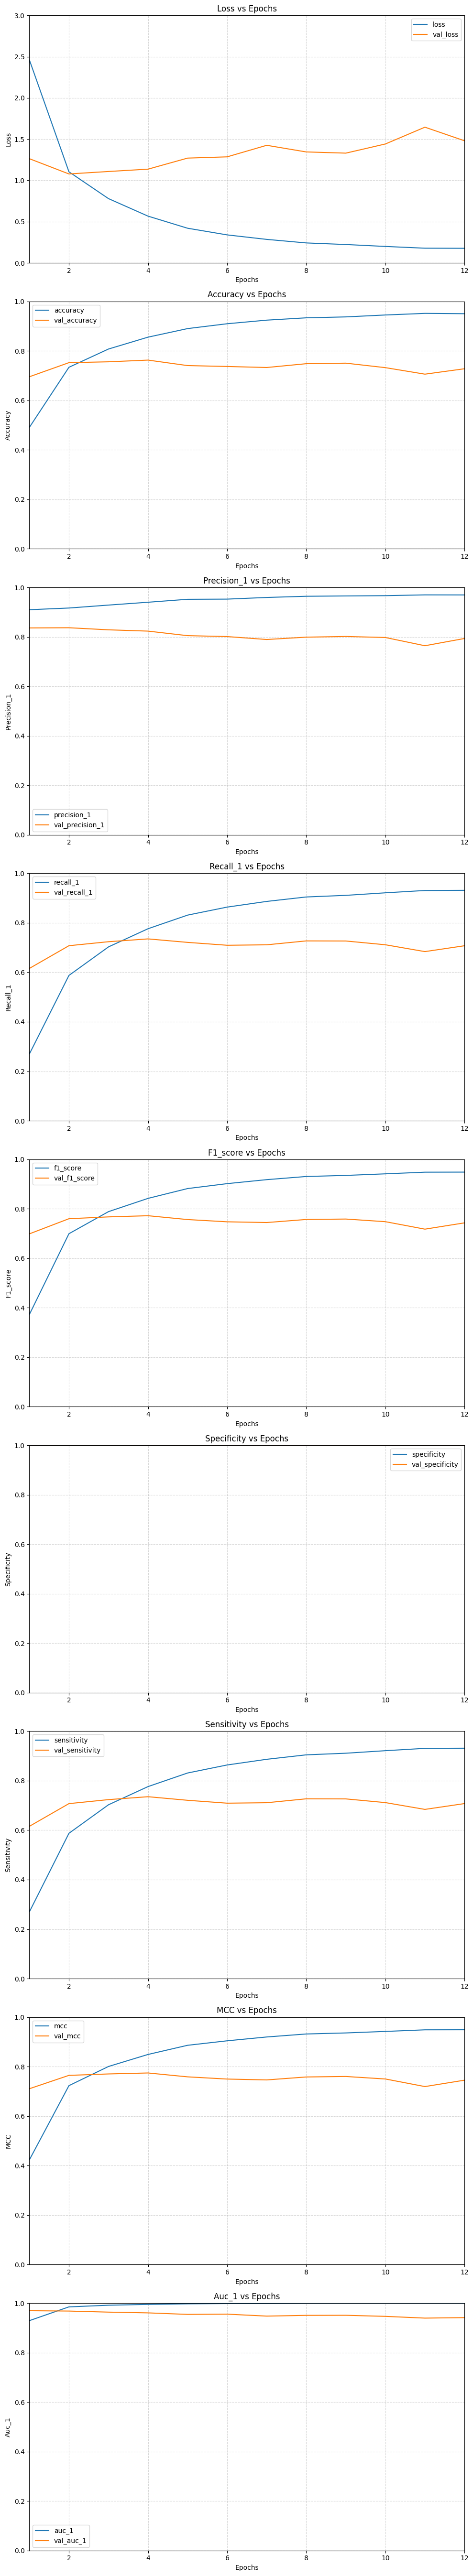

In [18]:
def plot_metrics(history, metric_name_list, figure_size=(10, 6)):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        history: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot
        figure_size: a tuple specifying the size of the figure (width, height)

    Returns:
        None
    """
    # Check if history is a valid Keras History object
    if not isinstance(history, type(tf.keras.callbacks.History())):
        raise ValueError("Invalid Keras History object provided.")

    num_metrics = len(metric_name_list)

    # Create subplots
    figure, axes = plt.subplots(num_metrics, figsize=(figure_size[0], figure_size[1] * num_metrics))

    # Define x-axis range
    rng = range(1, len(history.history[metric_name_list[0]]) + 1)

    for ax, metric_name in zip(axes, metric_name_list):
        # Check if the metric exists in the history
        if metric_name not in history.history:
            raise ValueError(f"Metric '{metric_name}' not found in the training history.")

        metric = history.history[metric_name]
        v_metric = history.history.get(f"val_{metric_name}", None)

        # Plot training metric
        ax.plot(rng, metric, label=metric_name)

        # Plot validation metric if available
        if v_metric is not None:
            ax.plot(rng, v_metric, label=f"val_{metric_name}")

        ax.legend()
        ax.set_xlabel("Epochs")

        # Set y-axis label and title
        ylabel = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_ylabel(ylabel)
        ax.set_title(f"{ylabel} vs Epochs")

        # Set y-axis limits
        max_loss = max(max(metric), max(v_metric)) if v_metric is not None else max(metric)
        min_loss = min(min(metric), min(v_metric)) if v_metric is not None else min(metric)
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()
    plt.show()

metric_names = ["loss", "accuracy", "precision_1", "recall_1", "f1_score",
                "specificity", "sensitivity", "mcc", "auc_1"]
plot_metrics(history, metric_names)

In [19]:
# Assuming you have a DataFrame 'df' with a 'labels' column
classes = df['labels'].unique()

# Convert predicted probabilities to class labels
predictions = model.predict(test_data)
predicted_labels = predictions.argmax(axis=1)

true_labels = test_data.classes
tests = len(true_labels)

# Calculate accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
accuracy_percentage = accuracy * 100

# Calculate the total number of errors
errors = np.sum(predicted_labels != true_labels)

# Print the classification report with class names and values in decimals
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

print(report)
print(f'There were {errors} errors in {tests} tests for an accuracy of {accuracy_percentage:6.2f}%')

511/511 [==============================] - 10s 17ms/step
                           precision    recall  f1-score   support

                     ak47     0.9630    0.9750    0.9689        80
            american-flag     0.6667    0.6000    0.6316        10
                 backpack     0.4348    1.0000    0.6061        10
             baseball-bat     0.9167    0.7333    0.8148        15
           baseball-glove     0.4000    0.4615    0.4286        13
          basketball-hoop     1.0000    0.7333    0.8462        15
                      bat     0.8333    0.5556    0.6667         9
                  bathtub     0.6667    0.7273    0.6957        11
                     bear     0.3188    0.9565    0.4783        23
                 beer-mug     1.0000    0.8000    0.8889        10
                billiards     0.8750    0.7778    0.8235         9
               binoculars     0.9643    0.9643    0.9643        28
                 birdbath     0.9524    0.9091    0.9302        22
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
